In [1]:
import urllib
from PIL import Image
import torchvision.transforms as T
import itertools
import math 
import torch.nn.functional as F
import numpy as np 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch

In [2]:
def load_image_from_url(url: str) -> Image:
    with urllib.request.urlopen(url) as f:
        return Image.open(f).convert("RGB")

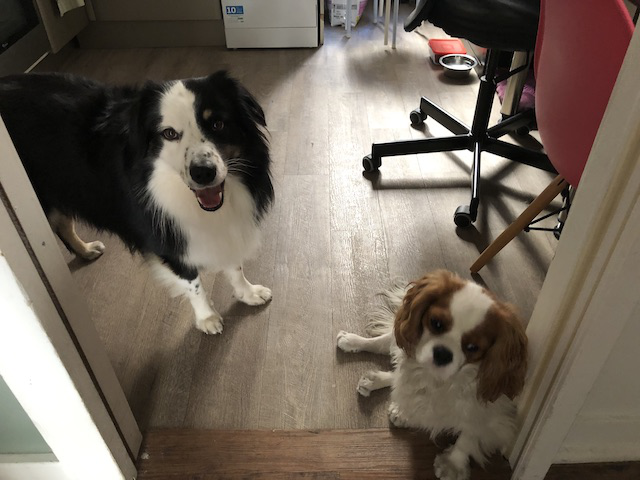

In [3]:
EXAMPLE_IMAGE_URL = "https://dl.fbaipublicfiles.com/dinov2/images/example.jpg"

image = load_image_from_url(EXAMPLE_IMAGE_URL)
display(image)

In [4]:
image.size

(640, 480)

In [5]:
dinov1_vitb8 = torch.hub.load('facebookresearch/dino:main', 'dino_vitb8').cuda()
dinov1_vitb8.eval()

Downloading: "https://github.com/facebookresearch/dino/zipball/main" to /home/yuqun/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_vitbase8_pretrain/dino_vitbase8_pretrain.pth" to /home/yuqun/.cache/torch/hub/checkpoints/dino_vitbase8_pretrain.pth


  0%|          | 0.00/327M [00:00<?, ?B/s]

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(8, 8), stride=(8, 8))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attent

In [25]:
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14').cuda()
dinov2_vitl14.eval()

Using cache found in /home/yuqun/.cache/torch/hub/facebookresearch_dinov2_main
/home/yuqun/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/yuqun/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/yuqun/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0): NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
    (1):

In [6]:
class CenterPadding(torch.nn.Module):
    def __init__(self, multiple = 8):
        super().__init__()
        self.multiple = multiple

    def _get_pad(self, size):
        new_size = math.ceil(size / self.multiple) * self.multiple
        pad_size = new_size - size
        pad_size_left = pad_size // 2
        pad_size_right = pad_size - pad_size_left
        return pad_size_left, pad_size_right

    @torch.inference_mode()
    def forward(self, x):
        pads = list(itertools.chain.from_iterable(self._get_pad(m) for m in x.shape[:1:-1]))
        output = F.pad(x, pads)
        return output


transform = T.Compose([
    # T.CenterCrop(224),
    T.ToTensor(),
    lambda x: x.unsqueeze(0),
    CenterPadding(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

In [39]:
with torch.no_grad():
    # features = dinov2_vitl14(transform(image).cuda())
    features = dinov1_vitb8.get_intermediate_layers(transform(image).cuda(), 2,)

In [40]:
features = [f[:, 1:] for f in features]
features = torch.cat(features, dim=-1)

In [41]:
features.shape

torch.Size([1, 4800, 1536])

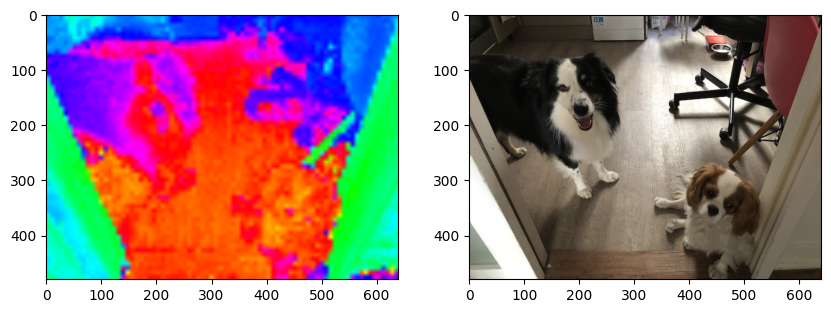

In [43]:
with torch.no_grad():
    # features = dinov2_vitl14(transform(image).cuda())
    features = dinov1_vitb8.get_intermediate_layers(transform(image).cuda(), 2)#["x_norm_patchtokens"]
features = [f[:, 1:] for f in features]
features = torch.cat(features, dim=-1)
pca = PCA(n_components=3) 
feature_np = features[0].cpu().numpy()[:, 1024:]
pca.fit(feature_np)

pca_features = pca.transform(feature_np) 


H, W = 480 // 8, 640 // 8
# pca_features_vis = F.normalize(torch.from_numpy(pca_features.reshape(35, 46, 3)), dim = -1).numpy() * 0.5 + 0.5
pca_features_np = pca_features.reshape(H, W, 3)
pca_feature_vis = (pca_features_np - pca_features_np.min(axis = -1)[..., None]) / (pca_features_np.max(axis = -1)[..., None] - pca_features_np.min(axis = -1)[..., None])

pca_feature_vis = T.CenterCrop((480, 640)) (F.interpolate(torch.from_numpy(pca_feature_vis).permute(2, 0, 1)[None], size = (H * 8, W * 8), mode = "bilinear", align_corners = False))[0].permute(1, 2, 0).numpy()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(pca_feature_vis)
plt.subplot(1, 2, 2)
plt.imshow(T.ToTensor()(image).permute(1,2,0))
plt.show()

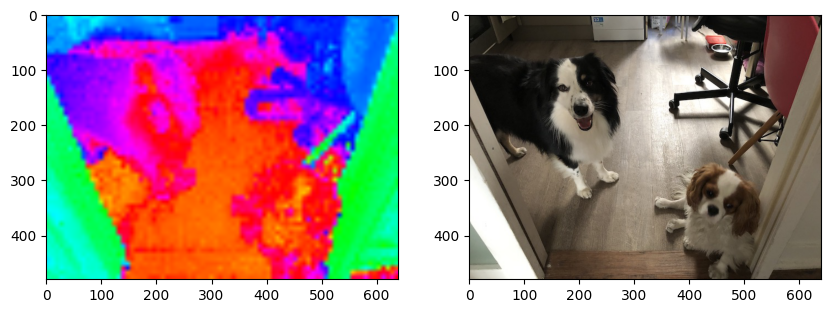

In [14]:
with torch.no_grad():
    # features = dinov2_vitl14(transform(image).cuda())
    features = dinov1_vitb8.get_intermediate_layers(transform(image).cuda(), 2)#["x_norm_patchtokens"]

pca = PCA(n_components=3) 
feature_np = features[0][:, 1:].cpu().numpy()[0]
pca.fit(feature_np)

pca_features = pca.transform(feature_np) 


H, W = 480 // 8, 640 // 8
# pca_features_vis = F.normalize(torch.from_numpy(pca_features.reshape(35, 46, 3)), dim = -1).numpy() * 0.5 + 0.5
pca_features_np = pca_features.reshape(H, W, 3)
pca_feature_vis = (pca_features_np - pca_features_np.min(axis = -1)[..., None]) / (pca_features_np.max(axis = -1)[..., None] - pca_features_np.min(axis = -1)[..., None])

pca_feature_vis = T.CenterCrop((480, 640)) (F.interpolate(torch.from_numpy(pca_feature_vis).permute(2, 0, 1)[None], size = (H * 8, W * 8), mode = "bilinear", align_corners = False))[0].permute(1, 2, 0).numpy()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(pca_feature_vis)
plt.subplot(1, 2, 2)
plt.imshow(T.ToTensor()(image).permute(1,2,0))
plt.show()